### References
- https://keras.io/examples/vision/autoencoder/


In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import metrics
from keras import layers
from keras.datasets import mnist
from keras.models import Model

def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array, lam):
    """Use poisson noise lambda"""
    array = np.random.poisson(array * lam) / lam
    return array



def display(array1, array2, array3=[]):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 =  [None] * n

    plt.figure(figsize=(20, 4))
    if len(array3) > 0:
        images3 = array3[indices, :]
        plt.figure(figsize=(20, 6))

    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(64, 64))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        img2arg = 2
        if image3 is not None:
            img2arg = 3
        ax = plt.subplot(img2arg, n, i + 1 + n)
        plt.imshow(image2.reshape(64, 64))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if image3 is not None:
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(image3.reshape(64, 64))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

def calculate_similarity(src, dst):
    # Squeeze out the third dimension if it's 1
    if src.shape[-1] == 1:
        src = np.squeeze(src, axis=-1)
    if dst.shape[-1] == 1:
        dst = np.squeeze(dst, axis=-1)
    ssim_score = metrics.structural_similarity(src, dst, data_range=src.max() - src.min())
    return ssim_score

 

### Denoising Functions

In [3]:

MAX_KERNEL_LENGTH = 31

def apply_mean_filter(src):
  dst = cv.blur(src, (MAX_KERNEL_LENGTH, MAX_KERNEL_LENGTH))
  return dst
    

def apply_gaussian_blur(src):
  dst = cv.GaussianBlur(src, (MAX_KERNEL_LENGTH, MAX_KERNEL_LENGTH), 0)
  return dst
  

def apply_median_filter(src):
  # Convert the image to grayscale and uint8 if necessary
  src = 255 * src # Now scale by 255
  src = src.astype(np.uint8)

  dst = cv.medianBlur(src, MAX_KERNEL_LENGTH)

  # convert back to float32
  dst = dst.astype(np.float32) / 255.0


  return dst


def apply_bilateral_filter(src):

  src = 255 * src # Now scale by 255
  src = src.astype(np.uint8)

  dst = cv.bilateralFilter(src.astype(np.uint8), MAX_KERNEL_LENGTH, MAX_KERNEL_LENGTH * 2, MAX_KERNEL_LENGTH / 2)

  # convert back to float32
  dst = dst.astype(np.float32) / 255.0
 
  
  return dst


### Helper functions for calculating average SSIM scores

In [4]:
def get_average_score(test_data, apply_fn):
    score = 0
    images = []
    for i in range(len(test_data)):
      img = apply_fn(test_data[i])
      images.append(img)
      score += calculate_similarity(test_data[i], img)

    return (score / len(test_data), np.array(images))



Importing images...
Finished importing train images
Finished importing test images


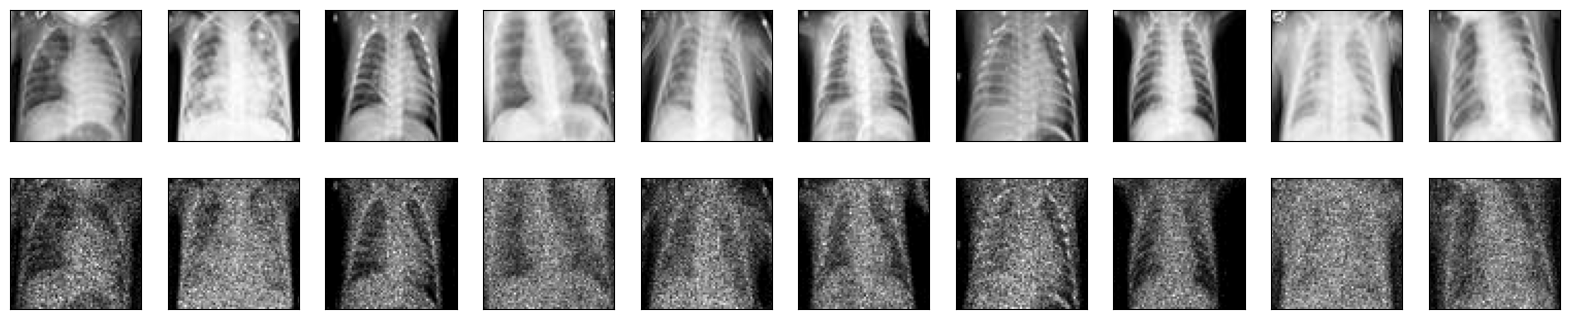

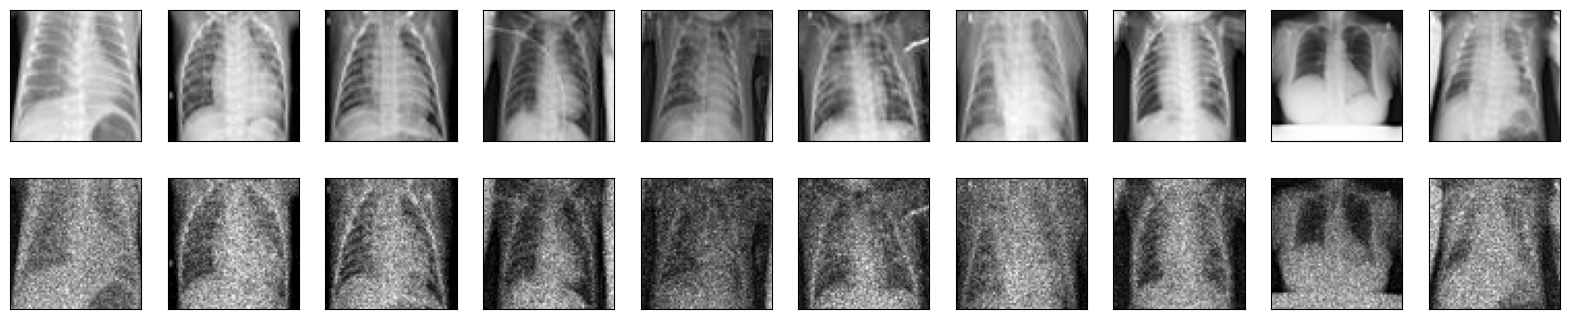

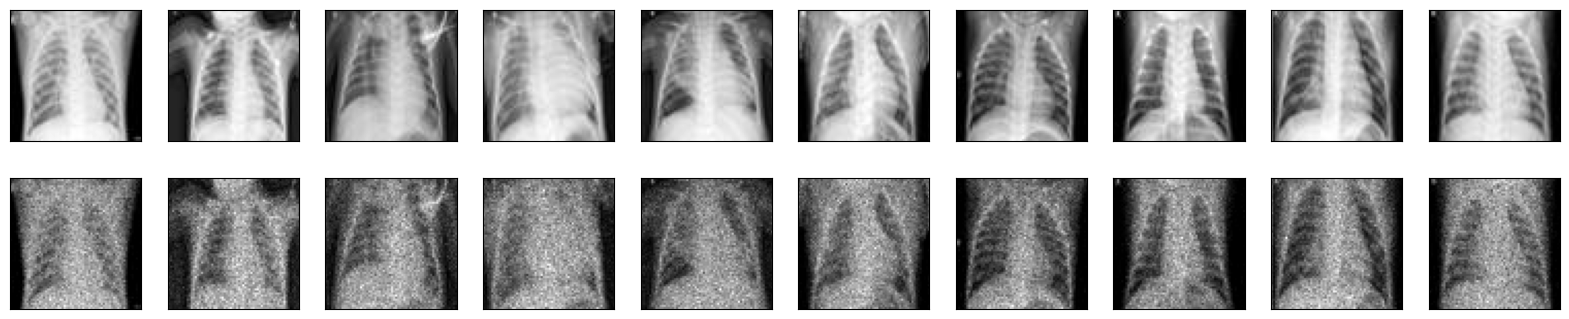

In [5]:
import os
import numpy as np
from keras.datasets import mnist
from keras.preprocessing import image




print('Importing images...')
train_data = []
train_image_names = os.listdir('../submission-2-denoising-autoencoders/train')
for i in range(len(train_image_names)):
    img = image.load_img(
        '../submission-2-denoising-autoencoders/train/' + train_image_names[i]
        , target_size=(64,64), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img / 255
    train_data.append(img)

train_data = np.array(train_data)
print("Finished importing train images")

# import images from ./test
test_data = []
test_image_names = os.listdir('../submission-2-denoising-autoencoders/test')


# Max 10 images
for i in range(len(test_image_names)):
    img = image.load_img(
        '../submission-2-denoising-autoencoders/test/' + test_image_names[i]
        , target_size=(64,64), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img / 255
    test_data.append(img)
    

test_data = np.array(test_data)
print("Finished importing test images")



# Normalize and reshape the data

# Create a copy of the data with added noise
noisy_train_data_25 = noise(train_data, 25)
noisy_test_data_25 = noise(test_data, 25)

noisy_train_data_50 = noise(train_data, 50)
noisy_test_data_50 = noise(test_data, 50)

noisy_train_data_75 = noise(train_data, 75)
noisy_test_data_75 = noise(test_data, 75)

# # Display the train data and a version of it with added noise

display(train_data, noisy_train_data_25)
display(train_data, noisy_train_data_50)
display(train_data, noisy_train_data_75)



In [19]:
from tensorflow.keras import layers, Model

def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj):
    path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path2)

    path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path3)

    path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(path4)

    return layers.concatenate([path1, path2, path3, path4], axis=-1)

input = layers.Input(shape=(64, 64, 1))
x = inception_module(input, 64, 96, 128, 16, 32, 32)
model = Model(input, x)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 64, 64, 96)           192       ['input_5[0][0]']             
                                                                                                  
 conv2d_18 (Conv2D)          (None, 64, 64, 16)           32        ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 1)            0         ['input_5[0][0]']             
 g2D)                                                                                       

In [20]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    shuffle=True,
		epochs=10,
		batch_size=10,
    validation_data=(test_data, test_data),
)

Epoch 1/10
185/185 [==============================] - 9s 48ms/step - loss: 0.5675 - val_loss: 0.5684
Epoch 2/10
185/185 [==============================] - 9s 49ms/step - loss: 0.5673 - val_loss: 0.5684
Epoch 3/10
185/185 [==============================] - 9s 47ms/step - loss: 0.5673 - val_loss: 0.5683
Epoch 4/10
185/185 [==============================] - 10s 52ms/step - loss: 0.5673 - val_loss: 0.5683
Epoch 5/10
185/185 [==============================] - 9s 47ms/step - loss: 0.5673 - val_loss: 0.5683
Epoch 6/10
185/185 [==============================] - 8s 46ms/step - loss: 0.5672 - val_loss: 0.5683
Epoch 7/10
185/185 [==============================] - 9s 46ms/step - loss: 0.5672 - val_loss: 0.5683
Epoch 8/10
185/185 [==============================] - 8s 45ms/step - loss: 0.5672 - val_loss: 0.5683
Epoch 9/10
185/185 [==============================] - 9s 46ms/step - loss: 0.5672 - val_loss: 0.5683
Epoch 10/10
185/185 [==============================] - 9s 47ms/step - loss: 0.5672 - val_l

15/15 [==============================] - 1s 37ms/step


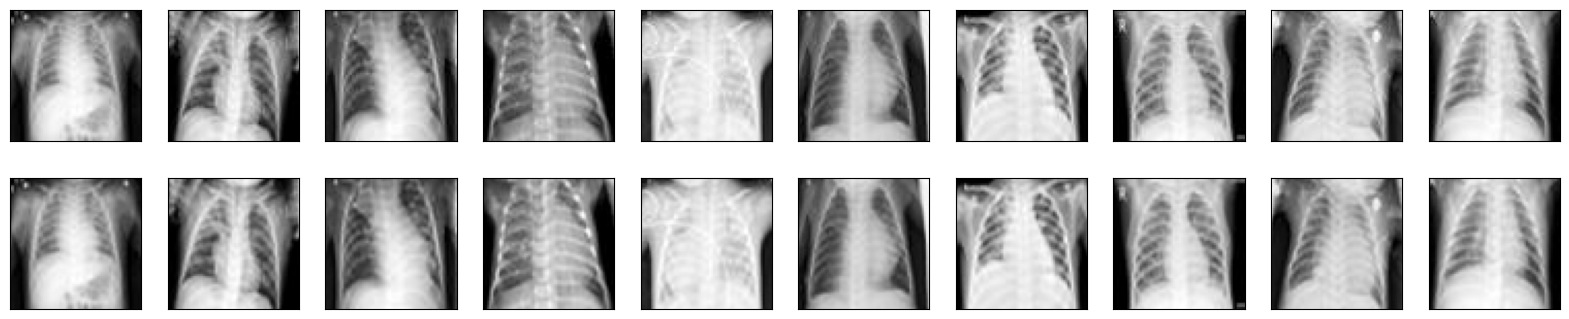

In [22]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [23]:
# Lambda 25
autoencoder.fit(
    x=noisy_train_data_25,
    y=train_data,
    epochs=100,
    batch_size=10,
    shuffle=True,
    validation_data=(noisy_test_data_25, test_data),
)

Epoch 1/100
185/185 [==============================] - 9s 50ms/step - loss: 0.5722 - val_loss: 0.5724
Epoch 2/100
185/185 [==============================] - 9s 50ms/step - loss: 0.5713 - val_loss: 0.5722
Epoch 3/100
185/185 [==============================] - 9s 47ms/step - loss: 0.5711 - val_loss: 0.5721
Epoch 4/100
185/185 [==============================] - 9s 47ms/step - loss: 0.5710 - val_loss: 0.5720
Epoch 5/100
185/185 [==============================] - 8s 46ms/step - loss: 0.5709 - val_loss: 0.5720
Epoch 6/100
185/185 [==============================] - 8s 46ms/step - loss: 0.5709 - val_loss: 0.5719
Epoch 7/100
185/185 [==============================] - 9s 46ms/step - loss: 0.5708 - val_loss: 0.5719
Epoch 8/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5708 - val_loss: 0.5719
Epoch 9/100
185/185 [==============================] - 8s 46ms/step - loss: 0.5708 - val_loss: 0.5718
Epoch 10/100
185/185 [==============================] - 9s 48ms/step - loss: 0.570

15/15 [==============================] - 1s 37ms/step


<Figure size 2000x400 with 0 Axes>

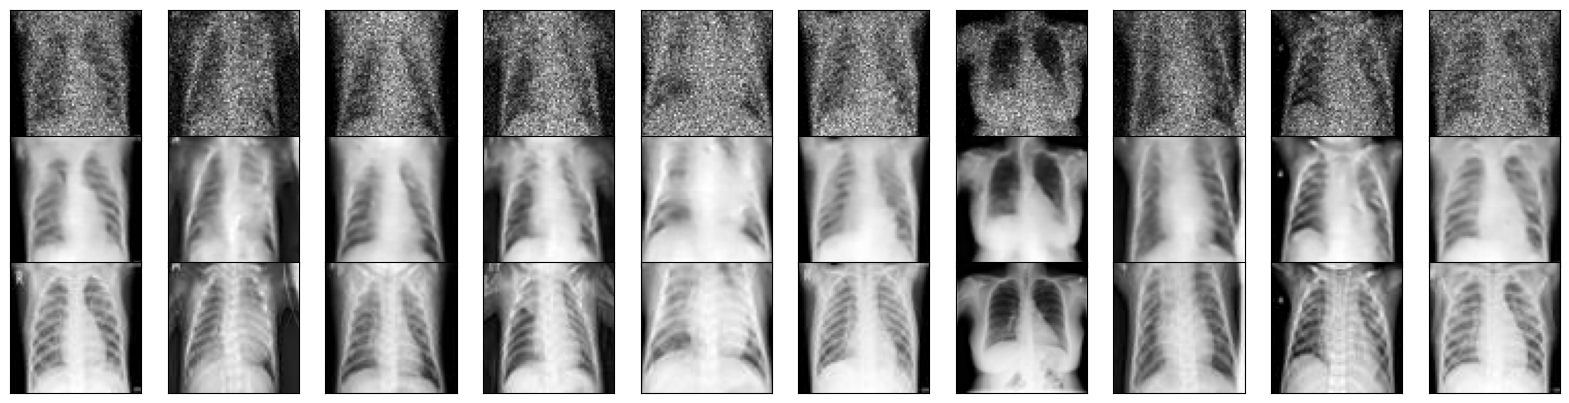

Lambda 25
Average SSIM:  0.8285555574307607
Average SSIM with mean filter:  0.08598321179053715
Average SSIM with gaussian blur:  0.173518412685902
Average SSIM with median filter:  0.13700159068542622
Average SSIM with bilateral filter:  0.5537243589521129


In [25]:
predictions = autoencoder.predict(noisy_test_data_25)

scores_25 = []
for i in range(len(predictions)):
	scores_25.append(calculate_similarity(test_data[i], predictions[i]))


res_mean_25 = get_average_score(noisy_test_data_25, apply_mean_filter)
res_gauss_25 = get_average_score(noisy_test_data_25, apply_gaussian_blur)
res_median_25 = get_average_score(noisy_test_data_25, apply_median_filter)
res_bi_25 = get_average_score(noisy_test_data_25, apply_bilateral_filter)

display(noisy_test_data_25, predictions, test_data)

print("Lambda 25")
print("Average SSIM: ", sum(scores_25) / len(scores_25))
print("Average SSIM with mean filter: ", res_mean_25[0])
print("Average SSIM with gaussian blur: ", res_gauss_25[0])
print("Average SSIM with median filter: ", res_median_25[0])
print("Average SSIM with bilateral filter: ", res_bi_25[0])



### Lambda 50

In [26]:

autoencoder.fit(
    x=noisy_train_data_50,
    y=train_data,
    epochs=100,
    batch_size=10,
    shuffle=True,
    validation_data=(noisy_test_data_50, test_data),
)

Epoch 1/100
185/185 [==============================] - 9s 47ms/step - loss: 0.5696 - val_loss: 0.5706
Epoch 2/100
185/185 [==============================] - 9s 50ms/step - loss: 0.5695 - val_loss: 0.5706
Epoch 3/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5695 - val_loss: 0.5706
Epoch 4/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5695 - val_loss: 0.5706
Epoch 5/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5695 - val_loss: 0.5706
Epoch 6/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5695 - val_loss: 0.5706
Epoch 7/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5695 - val_loss: 0.5706
Epoch 8/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5695 - val_loss: 0.5706
Epoch 9/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5695 - val_loss: 0.5706
Epoch 10/100
185/185 [==============================] - 8s 44ms/step - loss: 0.569

15/15 [==============================] - 1s 34ms/step


<Figure size 2000x400 with 0 Axes>

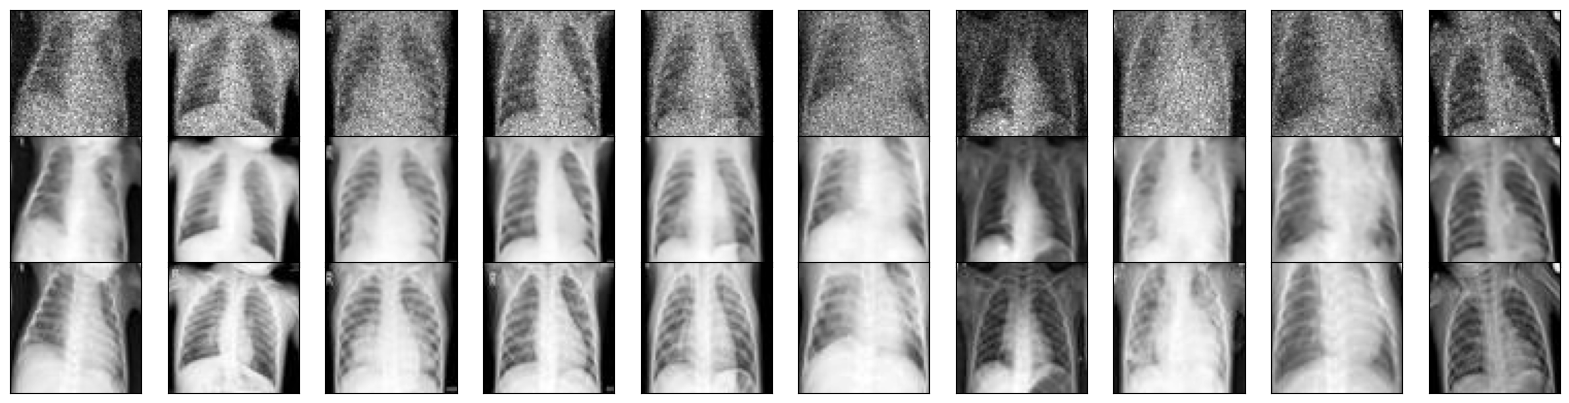

Lambda 50
Average SSIM:  0.8705058233275101
Average SSIM with mean filter:  0.10898430305724613
Average SSIM with gaussian blur:  0.22385713024490997
Average SSIM with median filter:  0.1776535615730698
Average SSIM with bilateral filter:  0.5737525053432939


In [27]:

predictions = autoencoder.predict(noisy_test_data_50)

scores_50 = []
for i in range(len(predictions)):
	scores_50.append(calculate_similarity(test_data[i], predictions[i]))


res_mean_50 = get_average_score(noisy_test_data_50, apply_mean_filter)
res_gauss_50 = get_average_score(noisy_test_data_50, apply_gaussian_blur)
res_median_50 = get_average_score(noisy_test_data_50, apply_median_filter)
res_bi_50 = get_average_score(noisy_test_data_50, apply_bilateral_filter)

display(noisy_test_data_50, predictions, test_data)

print("Lambda 50")
print("Average SSIM: ", sum(scores_50) / len(scores_50))
print("Average SSIM with mean filter: ", res_mean_50[0])
print("Average SSIM with gaussian blur: ", res_gauss_50[0])
print("Average SSIM with median filter: ", res_median_50[0])
print("Average SSIM with bilateral filter: ", res_bi_50[0])



### Lambda = 75

In [28]:

autoencoder.fit(
    x=noisy_train_data_75,
    y=train_data,
    epochs=100,
    batch_size=10,
    shuffle=True,
    validation_data=(noisy_test_data_75, test_data),
)

Epoch 1/100
185/185 [==============================] - 8s 46ms/step - loss: 0.5691 - val_loss: 0.5701
Epoch 2/100
185/185 [==============================] - 8s 43ms/step - loss: 0.5690 - val_loss: 0.5701
Epoch 3/100
185/185 [==============================] - 9s 47ms/step - loss: 0.5690 - val_loss: 0.5701
Epoch 4/100
185/185 [==============================] - 9s 47ms/step - loss: 0.5690 - val_loss: 0.5701
Epoch 5/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5690 - val_loss: 0.5701
Epoch 6/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5690 - val_loss: 0.5701
Epoch 7/100
185/185 [==============================] - 9s 48ms/step - loss: 0.5690 - val_loss: 0.5701
Epoch 8/100
185/185 [==============================] - 10s 52ms/step - loss: 0.5690 - val_loss: 0.5701
Epoch 9/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5690 - val_loss: 0.5701
Epoch 10/100
185/185 [==============================] - 9s 46ms/step - loss: 0.56

15/15 [==============================] - 1s 44ms/step


<Figure size 2000x400 with 0 Axes>

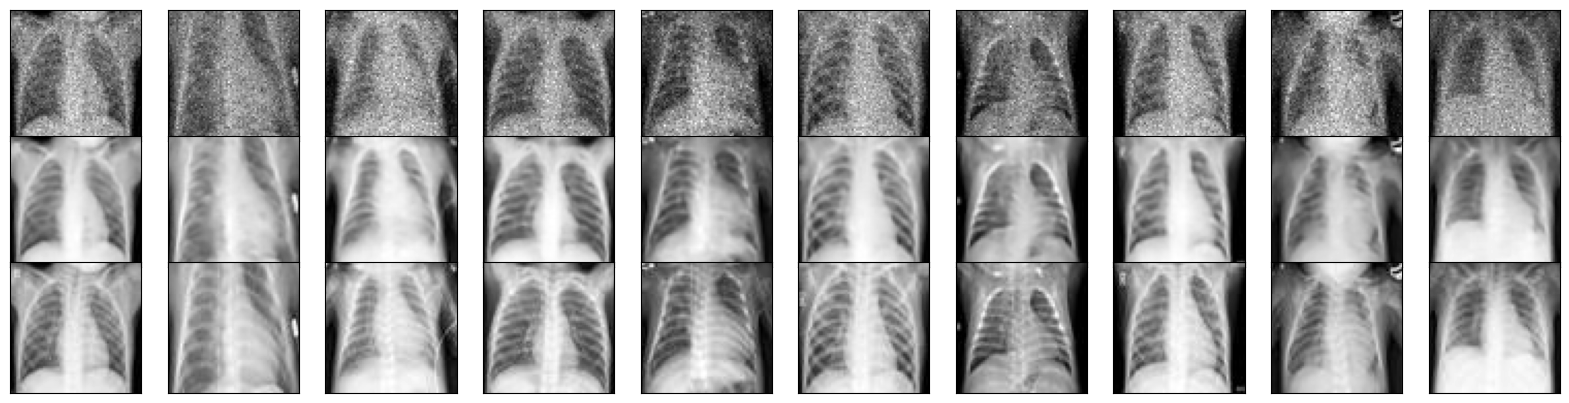

Lambda 75
Average SSIM:  0.8912405503096013
Average SSIM with mean filter:  0.12506921469442342
Average SSIM with gaussian blur:  0.25600522976779844
Average SSIM with median filter:  0.2016807982501995
Average SSIM with bilateral filter:  0.583441192585948


In [33]:

predictions = autoencoder.predict(noisy_test_data_75)

scores_75 = []
for i in range(len(predictions)):
	scores_75.append(calculate_similarity(test_data[i], predictions[i]))


res_mean_75 = get_average_score(noisy_test_data_75, apply_mean_filter)
res_gauss_75 = get_average_score(noisy_test_data_75, apply_gaussian_blur)
res_median_75 = get_average_score(noisy_test_data_75, apply_median_filter)
res_bi_75 = get_average_score(noisy_test_data_75, apply_bilateral_filter)

display(noisy_test_data_75, predictions, test_data)

print("Lambda 75")
print("Average SSIM: ", sum(scores_75) / len(scores_75))
print("Average SSIM with mean filter: ", res_mean_75[0])
print("Average SSIM with gaussian blur: ", res_gauss_75[0])
print("Average SSIM with median filter: ", res_median_75[0])
print("Average SSIM with bilateral filter: ", res_bi_75[0])



In [34]:
from beautifultable import BeautifulTable

table = BeautifulTable()
table.set_style(BeautifulTable.STYLE_MARKDOWN)
table.column_headers = ["","Lambda = 25", "Lambda = 50", "Lambda = 75"]

table.append_row([
	"Median Filter",
	res_median_25[0],
	res_median_50[0],
	res_median_75[0],
])

table.append_row([
	"Mean Filter",
	res_mean_25[0],
	res_mean_50[0],
	res_mean_75[0],
])

table.append_row([
	"Gaussian Blur",
	res_gauss_25[0],
	res_gauss_50[0],
	res_gauss_75[0],
])

table.append_row([
	"Bilateral Filter",
	res_bi_25[0],
	res_bi_50[0],
	res_bi_75[0],
])

table.append_row([
	"Autoencoder",
	sum(scores_25) / len(scores_25),
	sum(scores_50) / len(scores_50),
	sum(scores_75) / len(scores_75),
])



print(table)


|                  | Lambda = 25 | Lambda = 50 | Lambda = 75 |
|------------------|-------------|-------------|-------------|
|  Median Filter   |    0.137    |    0.178    |    0.202    |
|   Mean Filter    |    0.086    |    0.109    |    0.125    |
|  Gaussian Blur   |    0.174    |    0.224    |    0.256    |
| Bilateral Filter |    0.554    |    0.574    |    0.583    |
|   Autoencoder    |    0.829    |    0.871    |    0.891    |


|                  | Lambda = 25 | Lambda = 50 | Lambda = 75 |
|------------------|-------------|-------------|-------------|
|  Median Filter   |    0.137    |    0.178    |    0.202    |
|   Mean Filter    |    0.086    |    0.11     |    0.125    |
|  Gaussian Blur   |    0.173    |    0.224    |    0.256    |
| Bilateral Filter |    0.554    |    0.574    |    0.585    |
|   Autoencoder    |    0.804    |    0.865    |    0.865    |


a) Why is poisson distribution the ideal one to use to simulate noise for medical images? Why not gaussian or something else? Answer in terms of relevance of medical applications.


The method which x-ray images are captured is by using a detector that counts the number of photons that hit the detector. The emission of the photons from the X-ray source is a Poisson process, so using a poisson distrubution to sumulate noise is better for this case. 


b) Which one performed the best? Why do you think this is the case?

The autoencoder performed the best. This is because the autoencoder is trained specifically to denoise the x-ray images. The other filters meanwhile are not trained to denoise x-ray images. They are more general filters that are used to denoise images in general.


In [13]:
import pandas as pd

z_values = encode(train_data)

# Conveert to 2-d
z_values = z_values.reshape(z_values.shape[0], -1)

# Convert the list of z values into a DataFrame
z_df = pd.DataFrame(z_values)

# Save the DataFrame to a .csv file
z_df.to_csv('z_values.csv', index=False)


58/58 [==============================] - 1s 12ms/step


In [13]:
print(autoencoder.layers[4].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")


In [14]:
# Assuming `autoencoder` is your trained model and `x_val` is your validation set
from sklearn.metrics import mean_squared_error


reconstructed_images = autoencoder.predict(test_data)
vals = [mean_squared_error(test_data[i].flatten(), reconstructed_images[i].flatten()) for i in range(len(test_data))]
mse = np.mean(vals)

mse

15/15 [==============================] - 1s 34ms/step


0.0039673294

In [16]:
print("MSE: ", mse)

MSE:  0.0039673294



### SSIM Scores

Residual Skip Connections: 0.791 | 0.87 | 0.864    
Inception Module:        |    0.829    |    0.871    |    0.891    



1. Which approach performed better for this particular task of denoising?

Inception Module performed better for this particular task of denoising. It averaged a higher SSIM score than the Residual Skip Connections model.



2. What is the intuition behind the improved model which made it ideal for this particular task?

The Inception Module is ideal for this particular task because it is able to capture more information from the input image. It is able to capture more information from the input image because it uses multiple filters to capture different features from the input image. This allows the model to capture more information from the input image and thus denoise the image better.

